<a href="https://colab.research.google.com/github/amantimalsina/Mamba-SAE/blob/main/Analysis_Mamba_SAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install jaxtyping
#%pip install transformer_lens
%pip install git+https://github.com/callummcdougall/eindex.git

  Cloning https://github.com/callummcdougall/eindex.git to /tmp/pip-req-build-2m7s884m
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/eindex.git /tmp/pip-req-build-2m7s884m
  Resolved https://github.com/callummcdougall/eindex.git to commit 39da17a59dcce5caee35c9d00d4a22ba33efe722
  Preparing metadata (setup.py) ... done
  Created wheel for eindex-callum: filename=eindex_callum-0.1.1-py3-none-any.whl size=8325 sha256=e37809ff26236d421344147c8fca396c7a4d0b9eee862872f40acc0b76ea12b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-958_5bfu/wheels/be/f6/8f/ebc7ec9e5bc5dff7be37fdce107f68449672f9c79b5df9328a
Successfully built eindex-callum


In [ ]:
## Previous Imports:
# %%
import os
import json
import random
from pathlib import Path
import gc
from typing import List, Tuple, Union
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
# %%
import torch
import torch as t
from torch import nn, Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
# %%
import wandb
from tqdm.notebook import tqdm
import pprint
# %%
import argparse
# %%
from transformers import AutoTokenizer
import datasets
from datasets import load_dataset
from dataclasses import dataclass
# %%
from transformer_lens.utils import test_prompt
import circuitsvis as cv  # optional dep, install with pip install circuitsvis
from functools import partial
from transformer_lens.hook_points import HookPoint

from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)
# %%
import mamba_lens
from mamba_lens import HookedMamba

In [ ]:
# %%
DTYPES = {
    "fp32": t.float32,
    "fp16": t.float16,
    "bf16": t.bfloat16
} # Add this line to define DTYPES

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        t.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(t.nn.init.kaiming_uniform_(t.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(t.nn.init.kaiming_uniform_(t.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(t.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(t.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to(cfg["device"])

    def forward(self, x):
        #print(f"x.shape: {x.shape}")
        x_cent = x - self.b_dec
        #print(f"x_cent.shape: {x_cent.shape}")
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        #print(f"acts.shape: {acts.shape}")
        x_reconstruct = acts @ self.W_dec + self.b_dec
        #print(f"x_reconstruct.shape: {x_reconstruct.shape}")
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean()
        #print(f"l2_loss: {l2_loss}")
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        #print(f"l1_loss: {l1_loss}")
        loss = l2_loss + l1_loss
        #print(f"loss: {loss}")
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

    def get_version(self):
        version_list = [int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)]
        if len(version_list):
            return 1+max(version_list)
        else:
            return 0

    def save(self):
        version = self.get_version()
        torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
        with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
            json.dump(cfg, f)
        print("Saved as version", version)

    @classmethod
    def load(cls, version):
        cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
        return self

In [ ]:
def load_autoencoder_from_huggingface():
    state_dict = {}
    version_id = 72
    # Load the data from huggingface (both metadata and state dict)
    sae_data: dict = download_file_from_hf("amantimalsina/mamba-sae", f"{version_id}_cfg.json")
    new_state_dict: dict = download_file_from_hf("amantimalsina/mamba-sae", f"{version_id}.pt", force_is_torch=True)
    # Add new state dict to the existing one
    for k, v in new_state_dict.items():
        state_dict[k] = t.stack([state_dict[k], v]) if k in state_dict else v

    cfg = sae_data

    autoencoder = AutoEncoder(cfg)
    autoencoder.load_state_dict(state_dict)

    return autoencoder, cfg


autoencoder, cfg = load_autoencoder_from_huggingface()
autoencoder.to(cfg["device"])
autoencoder.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


AutoEncoder()

In [ ]:
model = mamba_lens.HookedMamba.from_pretrained(
                              "state-spaces/mamba-130m",
                              device='cuda'
                              )
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b')

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(model.cfg)

MambaCfg(d_model=768, n_layers=24, vocab_size=50280, d_state=16, expand=2, dt_rank=48, d_conv=4, pad_vocab_size_multiple=8, conv_bias=True, bias=False, default_prepend_bos=True, tokenizer_prepends_bos=False, n_ctx=2048, device='cuda', initializer_cfg=MambaInitCfg(initializer_range=(0.02,), rescale_prenorm_residual=(True,), n_residuals_per_layer=(1,), dt_init=('random',), dt_scale=(1.0,), dt_min=(0.001,), dt_max=(0.1,), dt_init_floor=0.0001), d_inner=1536)


In [ ]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)

In [ ]:
all_tokens = tokenized_data["tokens"][:cfg["num_tokens"],]
print("Tokens shape: ", all_tokens.shape)

Tokens shape:  torch.Size([100000, 128])


# Finding the Sparsity:

In [ ]:
@t.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "batch seq"],
    model: HookedMamba,
    autoencoder: AutoEncoder,
    activation_cache_key: str = cfg["act_name"],
) -> Float[Tensor, "instance n_hidden_ae"]:
    '''
    Returns the feature probabilities (i.e. fraction of time the feature is active) for each feature in the
    autoencoder, averaged over all `batch * seq` tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens,
                                          fast_ssm=True,
                                          fast_conv=True,
                                          warn_disabled_hooks=False,
                                          names_filter=activation_cache_key)
    act = cache[activation_cache_key]

    del logits, cache
    torch.cuda.empty_cache()
    gc.collect()
    assert act.shape == (batch_size, seq_len, model.cfg.d_model)

    acts = autoencoder.forward(act)[2]
    assert acts.shape == (batch_size, seq_len, cfg["dict_size"])

    return acts.mean(0)

In [ ]:
print(cfg)

{'num_tokens': 100000, 'batch_size': 32, 'act_name': 'hook_norm', 'dict_size': 1536, 'l1_coeff': 0.0003, 'beta1': 0.9, 'beta2': 0.999, 'dict_mult': 32, 'seq_len': 128, 'remove_rare_dir': False, 'device': 'cuda:0', 'enc_dtype': 'fp32', 'seed': 16, 'act_size': 768, 'model_batch_size': 32, 'num_epochs': 5, 'lr': 0.001, 'l1_weight': 1e-05, 'l2_weight': 1e-05, 'log_every': 50, 'eval_every': 100, 'recons_every': 500, 'save_every': 500, 'reset_freq_threshold': 3.162277660168379e-06, 'wandb_project': 'mamba_autoencoder', 'wandb_name': None, 'encoder_hidden_sizes': [512, 256], 'decoder_hidden_sizes': [256, 512], 'latent_dim': 64}


In [ ]:
# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i:i+50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-13-25291cef2950>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


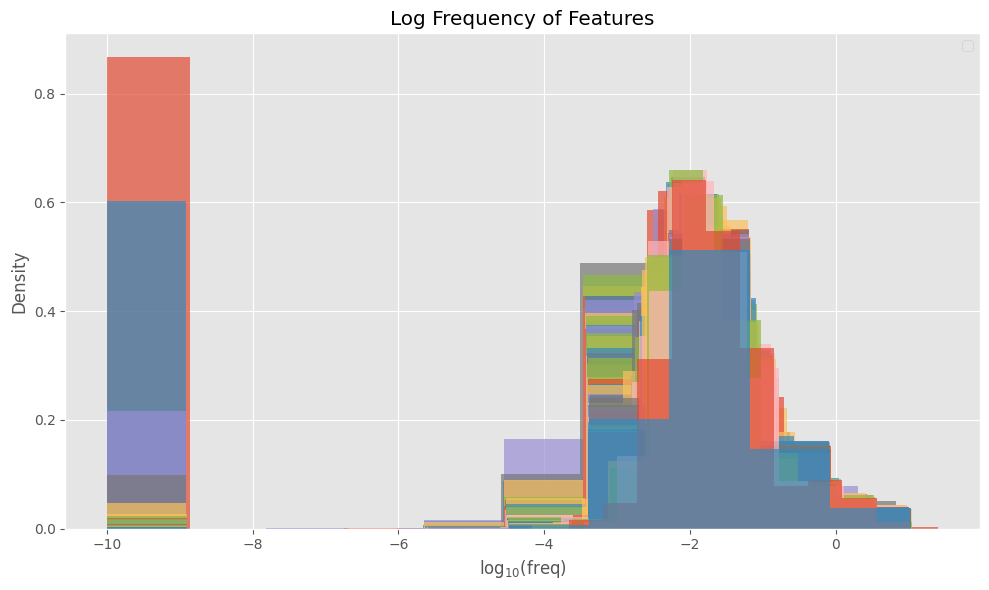

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 6))

for i, lf in enumerate(log_freq):
    # Move the tensor to CPU and convert to NumPy array
    lf_np = lf.cpu().numpy()

    ax.hist(
        lf_np,
        density=True,
        alpha=0.7,
        #label=f"Instance {i+1}"
    )

ax.set_xlabel("log$_{10}$(freq)")
ax.set_ylabel("Density")
ax.set_title("Log Frequency of Features")
ax.legend()

plt.tight_layout()
plt.show()

We can see that the features is _kind of_ bimodal. Similar to the Transformer 1-L inverstigations, there is a clear mode containing most of the important features.

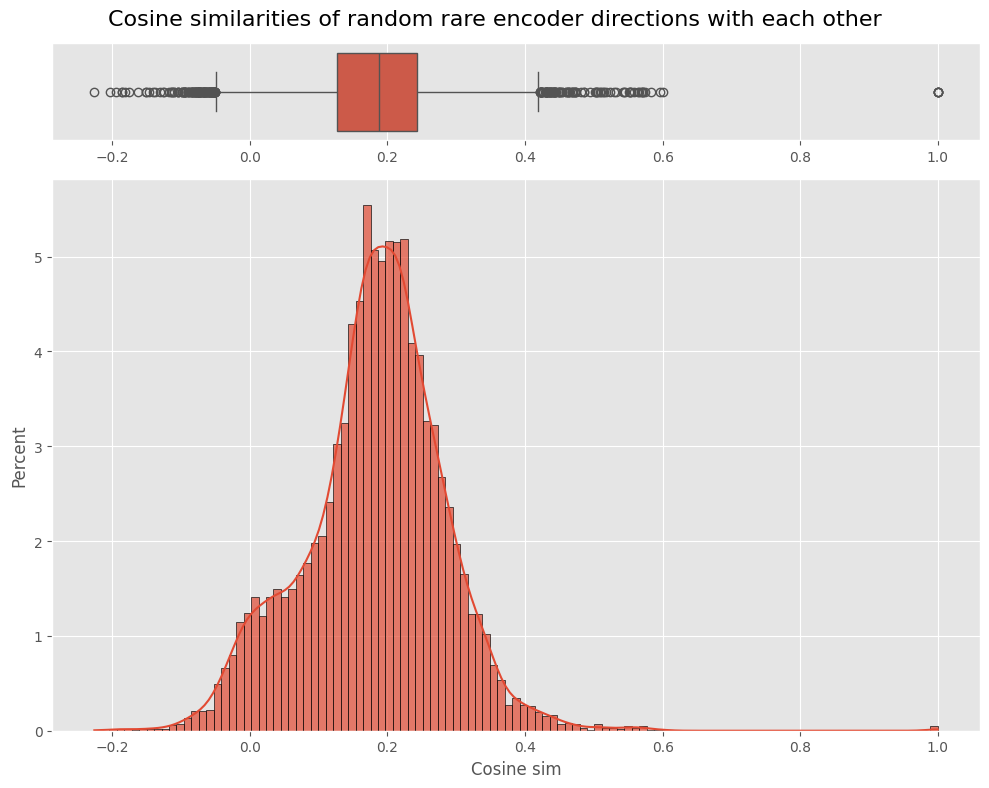

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get all the rare features
is_rare = feature_probability[0] < 1e-4
rare_encoder_directions = autoencoder.W_enc[:, is_rare]
rare_encoder_directions_normalized = rare_encoder_directions / rare_encoder_directions.norm(dim=0, keepdim=True)

# Compute their pairwise cosine similarities & sample randomly from this N*N matrix of similarities
cos_sims_rare = (rare_encoder_directions_normalized.T @ rare_encoder_directions_normalized).flatten()
cos_sims_rare_random_sample = cos_sims_rare[t.randint(0, cos_sims_rare.shape[0], (10000,))]


# Create the histogram
cos_sims_numpy = cos_sims_rare_random_sample.detach().cpu().numpy()

# Create the main figure and axis
fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(10, 8),
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})
fig.suptitle("Cosine similarities of random rare encoder directions with each other",
             fontsize=16)

# Create the histogram
sns.histplot(cos_sims_numpy, ax=ax_hist, kde=True, stat="percent",
             edgecolor='black', alpha=0.7)
ax_hist.set_xlabel("Cosine sim")
ax_hist.set_ylabel("Percent")

# Create the box plot
sns.boxplot(x=cos_sims_numpy, ax=ax_box, orient="h")
ax_box.set(xlabel='')  # Remove x-label from box plot
ax_box.set(yticks=[])  # Remove y-ticks from box plot

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

The plot shows a roughly normal (Gaussian) distribution centered around 0.2.
The peak of the distribution is at approximately 0.2. This suggests that, on average, the random rare encoder directions have a slight positive correlation with each other.

The fact that the average cosine similarity is around 0.2 suggests that these "random" rare encoder directions are not perfectly orthogonal to each other. They have a slight tendency to point in similar directions. Despite the slight positive correlation, most encoder directions are still quite distinct from each other, as evidenced by the relatively low cosine similarities. The outliers near 1.0 suggest that occasionally, some rare encoder directions align very closely with others which is quite interesting.

# find the reconstruction loss

In [ ]:
@t.no_grad()
def replacement_hook(pre_linear, hook, encoder):
    pre_linear_reconstr = encoder(pre_linear)[1]
    return pre_linear_reconstr

def mean_ablate_hook(pre_linear, hook):
    pre_linear[:] = pre_linear.mean([0, 1])
    return pre_linear

def zero_ablate_hook(pre_linear, hook):
    pre_linear[:] = 0.
    return pre_linear

@torch.no_grad()
def get_reconstruction_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = autoencoder
    loss_list = []
    for i in range(num_batches):
        tokens = all_tokens[t.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        loss = model(tokens, return_type="loss")
        recons_loss = model.run_with_hooks(tokens, return_type="loss",
                                           fast_ssm=True,
                                           fast_conv=True,
                                           fwd_hooks=[(cfg["act_name"], partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(cfg["act_name"], mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss",
                                             fast_ssm=True,
                                             fast_conv=True,
                                             fwd_hooks=[(cfg["act_name"], zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = t.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(loss, recons_loss, zero_abl_loss)
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"{score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss


reconstruction_loss = get_reconstruction_loss(local_encoder=autoencoder)
print(reconstruction_loss)

2.652313470840454 7.819022178649902 10.825362205505371
36.78%
(0.3678358131041689, 2.652313470840454, 7.819022178649902, 10.825362205505371)


# Interpreting individual features

In [ ]:
import torch as t
from torch import Tensor
from typing import Tuple, List
from rich import print as rprint
from rich.table import Table

@t.inference_mode()
def highest_activating_tokens(
    tokens: t.Tensor,
    model: HookedMamba,
    autoencoder: AutoEncoder,
    feature_idx: int,
    k: int = 10,
    activation_cache_key: str = cfg["act_name"]
) -> Tuple[t.Tensor, t.Tensor]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run
    logits, cache = model.run_with_cache(tokens,
                                         fast_ssm=True,
                                         fast_conv=True,
                                         warn_disabled_hooks=False,
                                         names_filter=activation_cache_key)
    act = cache[activation_cache_key]

    del logits, cache
    torch.cuda.empty_cache()
    gc.collect()



    # Compute activations
    x_acts = autoencoder.forward(act)[2]
    acts = x_acts[:, :, feature_idx]

    # Get the top k largest activations
    top_acts_values, top_acts_indices = acts.reshape(-1).topk(k)

    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return t.stack([top_acts_batch, top_acts_seq], dim=1), top_acts_values

def display_top_sequences(top_acts_indices: t.Tensor, top_acts_values: t.Tensor, tokens: t.Tensor, model: HookedMamba):
    table = Table("Sequence", "Activation", title="Tokens which most activate this feature")

    for (batch_idx, seq_idx), value in zip(top_acts_indices.tolist(), top_acts_values.tolist()):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq = ""
        for i in range(max(seq_idx-5, 0), min(seq_idx+5, tokens.shape[1])):
            new_str_token = model.to_single_str_token(tokens[batch_idx, i].item()).replace("\n", "\\n")
            # Highlight the token with the high activation
            if i == seq_idx:
                new_str_token = f"[b u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Add the sequence and activation value to the table
        table.add_row(seq, f'{value:.2f}')

    rprint(table)

# Usage
def analyze_multiple_features(
    tokens: t.Tensor,
    model: HookedMamba,
    autoencoder: AutoEncoder,
    feature_idx_start: int = 0,
    feature_idx_end: int = model.cfg.d_model,
    num_features: int = 500,
    k: int = 10,
    activation_cache_key: str = cfg["act_name"]
):
    for feature_idx in range(feature_idx_start, feature_idx_end, num_features):
        print(f"\nAnalyzing feature {feature_idx}:")
        top_acts_indices, top_acts_values = highest_activating_tokens(tokens, model, autoencoder, feature_idx, k, activation_cache_key)
        display_top_sequences(top_acts_indices, top_acts_values, tokens, model)

# Usage
tokens = all_tokens[:200]
analyze_multiple_features(tokens, model, autoencoder)


Analyzing feature 0:


                   Tokens which most activate this feature                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                                      ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ ,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND             │ 3.91       │
│ ,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND             │ 3.74       │
│ # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either        │ 2.61       │
│  of\n# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE    │ 2.17       │
│ # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either        │ 2.06       │
│ future__ import unicode_literals, print_                      │ 1.80       │
│  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express │ 1.67       │
│  Collins shatters this myth, demonstrating that no            │ 1.36       │
│  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express │ 1.25       │
│ # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.        │ 1.25       │
└───────────────────────────────────────────────────────────────┴────────────┘


Analyzing feature 500:


         Tokens which most activate this feature         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                 ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ get('HTTP_API_KEY', '')\n                │ 3.33       │
│ _type = CONTENT_TYPE_APPLICATION         │ 2.98       │
│ ACCOUNT_EMAIL_VERIFICATION =             │ 2.92       │
│ CONNECTION_NOT_EXISTS,\n                 │ 2.86       │
│ \nOBJECT_INFORMATION_CLASS.MaxObject     │ 2.82       │
│  provide your own!\nRECEIVER = '         │ 2.81       │
│  '...'\nSMTP_USERNAME = '                │ 2.76       │
│ \nOBJECT_INFORMATION_CLASS.ObjectHandle  │ 2.76       │
│ A.get('HTTP_API_KEY',                    │ 2.74       │
│ ': 'models.SET_NULL', 'blank             │ 2.69       │
└──────────────────────────────────────────┴────────────┘

# find a feature's logit effect

In [ ]:
import torch as t
from torch import Tensor
from typing import Tuple, List
from rich import print as rprint
from rich.table import Table

@t.no_grad()
def get_feature_probability(
    tokens: t.Tensor,
    model: HookedMamba,
    autoencoder: AutoEncoder,
    activation_cache_key: str = cfg["act_name"],
) -> t.Tensor:
    '''
    Returns the feature probabilities (i.e. fraction of time the feature is active) for each feature in the
    autoencoder, averaged over all `batch * seq` tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens,
                                         fast_ssm=True,
                                         fast_conv=True,
                                         warn_disabled_hooks=False,
                                         names_filter=activation_cache_key)
    act = cache[activation_cache_key]
    assert act.shape == (batch_size, seq_len, model.cfg.d_model)

    acts = autoencoder.forward(act)[2]
    assert acts.shape == (batch_size, seq_len, cfg["dict_size"])

    return acts.mean([0, 1])  # Average over both batch and sequence dimensions

def get_highest_probability_features(
    tokens: t.Tensor,
    model: HookedMamba,
    autoencoder: AutoEncoder,
    k: int = 10,
    activation_cache_key: str = cfg["act_name"],
) -> Tuple[t.Tensor, t.Tensor]:
    '''
    Returns the indices and probabilities of the k features with the highest activation probability.
    '''
    feature_probs = get_feature_probability(tokens, model, autoencoder, activation_cache_key)
    #print(feature_probs.shape)
    top_probs, top_indices = feature_probs.topk(k)
    return top_indices, top_probs

def display_top_features(top_indices: t.Tensor, top_probs: t.Tensor):
    table = Table("Feature Index", "Activation Probability", title="Features with Highest Activation Probability")
    for idx, prob in zip(top_indices.tolist(), top_probs.tolist()):
        table.add_row(str(idx), f'{prob:.4f}')
    rprint(table)

def get_logit_effect(feature_idx: int):
    #print(autoencoder.W_dec.shape)
    W_dec_vector = autoencoder.W_dec[feature_idx,:]
    #print(W_dec_vector.shape)

    W_dec_logits = W_dec_vector @ model.lm_head.weight.T

    top_tokens = W_dec_logits.topk(10)
    bottom_tokens = W_dec_logits.topk(10, largest=False)

    s = "Top tokens:\n"
    for token, value in zip(top_tokens.indices, top_tokens.values):
        s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
    s += "\nBottom tokens:\n"
    for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
        s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
    rprint(s)

# Usage
tokens = all_tokens[:200]  # Adjust this to your desired batch size
top_indices, top_probs = get_highest_probability_features(tokens, model, autoencoder)
display_top_features(top_indices, top_probs)

# If you want to analyze these high-probability features
for feature_idx in top_indices.tolist():
    print(f"\nAnalyzing high-probability feature {feature_idx}:")
    top_acts_indices, top_acts_values = highest_activating_tokens(tokens, model, autoencoder, feature_idx)
    display_top_sequences(top_acts_indices, top_acts_values, tokens, model)
    get_logit_effect(feature_idx)

     Features with Highest Activation     
               Probability                
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Feature Index ┃ Activation Probability ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1376          │ 9.5582                 │
│ 1054          │ 9.4932                 │
│ 1305          │ 6.3509                 │
│ 1013          │ 5.6698                 │
│ 884           │ 5.5407                 │
│ 1017          │ 5.1247                 │
│ 47            │ 4.8293                 │
│ 90            │ 4.0147                 │
│ 1253          │ 3.9632                 │
│ 929           │ 3.8601                 │
└───────────────┴────────────────────────┘


Analyzing high-probability feature 1376:


             Tokens which most activate this feature             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                         ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ type == "steady-state": \n\n                     │ 36.93      │
│  to deal with technology and (here’s the         │ 36.75      │
│ noRNA']-neg_data['Start_                         │ 36.31      │
│ ['frac']=neg_data['diff']                        │ 36.06      │
│ ['diff']/(neg_data['Stop_                        │ 35.40      │
│  with a GAS he/she belongs to\n                  │ 35.08      │
│  estimate (for a steady-state simulation only)." │ 34.70      │
│ .keras.io/building-autoenc                       │ 34.04      │
│ \n\n    def __init__(self, alpha=                │ 33.65      │
│ np.abs(pos_data['Start_                          │ 33.37      │
└──────────────────────────────────────────────────┴────────────┘

Top tokens:
(0.78) international
(0.78) football
(0.77) the
(0.77) you
(0.77) sound
(0.77) research
(0.77) inter
(0.77) from
(0.77) import
(0.77) super

Bottom tokens:
(0.34) ��
(0.35) medsc
(0.38)  doxor
(0.41) }{~
(0.42)  cryptocur
(0.42) ÃÂ
(0.43) ortunately
(0.43)  teasp
(0.44)  affidav
(0.44) acebook


Analyzing high-probability feature 1054:


                 Tokens which most activate this feature                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                                 ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  2  # make patterns happy\n        iterator =            │ 41.59      │
│ <|endoftext|> was such a marvelous minute since although │ 41.43      │
│ in-keras.html\ndef sampling(                             │ 41.08      │
│  selenium, the behavior is different.\n    #             │ 40.98      │
│  access page after passing entrance exam\n        """\n  │ 40.67      │
│ )\n# join the genes                                      │ 40.65      │
│  Let's insert three CEO names, companies and salaries    │ 40.41      │
│  likely want to filter more broadly.\n  options          │ 40.40      │
│  the GARMIN activity links for selected\n#               │ 40.31      │
│ \nFunctions used for ROI manipulation.\n\nAuthors        │ 40.31      │
└──────────────────────────────────────────────────────────┴────────────┘

Top tokens:
(0.28) 

(0.26) .
(0.25) :
(0.25) /
(0.25)  (
(0.24) ;
(0.24) -
(0.24) )
(0.22) (
(0.22) '

Bottom tokens:
(-0.40) PDATE
(-0.40)  triglycer
(-0.39) acebook
(-0.38) oddsidemargin
(-0.38)  cryptocur
(-0.37) opyright
(-0.37) ariju
(-0.36) ��
(-0.34) []$
(-0.34) icrosoft


Analyzing high-probability feature 1305:


                        Tokens which most activate this feature                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                                               ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ <|endoftext|>', type=str, required=True,                               │ 19.46      │
│ k_save_path, data_type,                                                │ 19.38      │
│         self.prefixList=prefixList\n                                   │ 18.60      │
│ _symjump(p, a):\n                                                      │ 18.47      │
│ utor_target=(str, unicode),\n                                          │ 18.37      │
│ 8_file(fp, ustr):\n                                                    │ 18.35      │
│ .join(dirname, var.name)\n                                             │ 18.25      │
│ (self,basePath,depth=0,                                                │ 18.21      │
│ bin',\n    #                                                     'data │ 18.16      │
│ FLAGS.data_dir, 'cifar-                                                │ 18.11      │
└────────────────────────────────────────────────────────────────────────┴────────────┘

Top tokens:
(0.67) )
(0.67) `
(0.66) ')
(0.65) *)
(0.63) )*(
(0.62)  `
(0.61) )*
(0.61) `)
(0.61) =`
(0.61) /*

Bottom tokens:
(-0.20)  cryptocur
(-0.17) ICENSE
(-0.15) widet
(-0.15) oddsidemargin
(-0.13)  triglycer
(-0.12) PDATE
(-0.10) ORANDUM
(-0.08)  $[]$
(-0.08) 

 
(-0.06) ...\...\


Analyzing high-probability feature 1013:


                 Tokens which most activate this feature                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                                  ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ <|endoftext|> [] # file raw\n                             │ 23.28      │
│         """Returns channels filtered wit filt function""" │ 22.87      │
│  != 1:\n            jah = self.hn                         │ 22.71      │
│ 0) * Tsun**(5.0/                                          │ 22.62      │
│ rain==0 ) )+( np.all(                                     │ 22.34      │
│ <|endoftext|> objs[1]["                                   │ 22.10      │
│  84):\n                                         for e in  │ 22.05      │
│ range(len                                                 │            │
│ ink <swkeemink@scimail                                    │ 21.96      │
│ be / project-camelot@conceptive                           │ 21.95      │
│ (OMDOT, porb, e):                                         │ 21.93      │
└───────────────────────────────────────────────────────────┴────────────┘

Top tokens:
(-0.74) -
(-0.76) /
(-0.76)  the
(-0.76)  to
(-0.77)  in
(-0.77)  with
(-0.77)  and
(-0.77)  is
(-0.78)  of
(-0.78) the

Bottom tokens:
(-1.41) acebook
(-1.33) PDATE
(-1.33)  entreprene
(-1.32)  Palestin
(-1.32) 14514
(-1.32) opyright
(-1.32)  /*!
(-1.31) 

 
(-1.31) oddsidemargin
(-1.31) izontal


Analyzing high-probability feature 884:


             Tokens which most activate this feature              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                          ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 100.0)\n\n        return (int(                    │ 24.65      │
│  s, v):\n\n        rgb = colorsys                 │ 24.53      │
│ (*fracs)\n        return (int(                    │ 23.97      │
│  c, r):\n        return self.arr                  │ 23.70      │
│ els(self):\n        return [self.                 │ 23.63      │
│  range(n):\n  draw.text((                         │ 23.49      │
│ .getSize()\n\n    cstr = p                        │ 23.04      │
│ () / m)\n            X = chain([                  │ 23.00      │
│ varnames())):\n                    slice_varnames │ 22.98      │
│ .\n\n        """\n        if self.enabled         │ 22.97      │
└───────────────────────────────────────────────────┴────────────┘

Top tokens:
(0.78) \
(0.76) }\
(0.74) $\
(0.74) {\
(0.73) _>
(0.73) _\
(0.73) !\
(0.73) *\
(0.73) \_
(0.73) _

Bottom tokens:
(0.20)  doxor
(0.22) gorithm
(0.22)  triglycer
(0.24) enment
(0.25)  Gmb
(0.26) ��
(0.27) tocol
(0.28) utative
(0.28)  algorith
(0.30) scious


Analyzing high-probability feature 1017:


              Tokens which most activate this feature              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                           ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  and became provincial of his order in Ireland. In │ 26.09      │
│  one\n        # we have to do it after             │ 26.09      │
│  live with the devil I know, so to speak           │ 25.54      │
│  He is well-mannered.', 'positive'),               │ 25.49      │
│  the tools that you gave me. When I see            │ 25.47      │
│  can be your trustable partner and if someone is   │ 25.41      │
│  I know, so to speak. Still, it                    │ 25.40      │
│ , so I do it again (                               │ 25.38      │
│  make an appeal, reapplied and was given a         │ 25.37      │
│  salaries into our ceos table.\nc.                 │ 25.27      │
└────────────────────────────────────────────────────┴────────────┘

Top tokens:
(-0.01) acebook
(-0.13) opyright
(-0.14) iscussion
(-0.15) idopsis
(-0.16)  LINEAR
(-0.17) ariju
(-0.17) icrosoft
(-0.17)  Palestin
(-0.17)  predecess
(-0.18) bsy

Bottom tokens:
(-1.04) 

(-1.01)  
(-0.97)  is
(-0.97) in
(-0.97) s
(-0.96)  (
(-0.96)  and
(-0.96)  with
(-0.96)  to
(-0.95) to


Analyzing high-probability feature 47:


              Tokens which most activate this feature               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                            ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ <|endoftext|> [] # file raw\n                       │ 21.00      │
│ """\n        from gf.gas.models                     │ 20.26      │
│  is related to:\n        1) withdrawal appointments │ 20.10      │
│ .strip()\n\n            svcstr = ","                │ 20.01      │
│ 0) * Tsun**(5.0/                                    │ 20.00      │
│  84):\n                                         for │ 19.90      │
│ e in range(len                                      │            │
│ en',M="4/4",transpose                               │ 19.88      │
│ \n            errs = etrain + np.                   │ 19.78      │
│ emink <swkeemink@scim                               │ 19.61      │
│ .mechanism = mecha.mechan                           │ 19.60      │
└─────────────────────────────────────────────────────┴────────────┘

Top tokens:
(-0.78) -
(-0.79) the
(-0.80) /
(-0.81) in
(-0.81)  the
(-0.81) I
(-0.81) to
(-0.81)  I
(-0.81) .
(-0.81) 1

Bottom tokens:
(-1.24) acebook
(-1.20)  entreprene
(-1.19)  Palestin
(-1.19)  triglycer
(-1.18) 14514
(-1.18) izontal
(-1.17)  /*!
(-1.17) PDATE
(-1.17) opyright
(-1.17)  questionna


Analyzing high-probability feature 90:


                Tokens which most activate this feature                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                                ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ ))\n                    remote_varnames.append(         │ 19.20      │
│  None\n\n        # allow migrations for ContentDatabase │ 17.45      │
│     # for f in filenames:\n                             │ 16.95      │
│  an assignment, he always equips us with what           │ 16.76      │
│ # for f in filenames:\n                                 │ 16.58      │
│ no_employee_registration_ids')\n                        │ 16.53      │
│ to': "orm['cyclope.Author']                             │ 16.43      │
│ ._collected_hw_info:\n                                  │ 16.37      │
│ filters = options.dev_filters or ['ATTR                 │ 16.03      │
│ _ctx.split_varnames())):\n                              │ 16.01      │
└─────────────────────────────────────────────────────────┴────────────┘

Top tokens:
(0.15) oids
(0.14) ists
(0.13) iations
(0.13) idences
(0.12) ials
(0.12) idents
(0.12) ies
(0.12) ators
(0.12) ites
(0.11) orphisms

Bottom tokens:
(-0.44)  Leban
(-0.41) CHANTABILITY
(-0.39) uvant
(-0.37) CUSS
(-0.37) �
(-0.37)  CURI
(-0.37) oddsidemargin
(-0.37)  triglycer
(-0.36) ALSE
(-0.36)  doxor


Analyzing high-probability feature 1253:


               Tokens which most activate this feature               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                             ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ self.last_update = None\n        logging             │ 22.85      │
│ rtime = time() + self.reload_                        │ 22.70      │
│ self.last_update = entry.mtime                       │ 22.61      │
│ :\n            for fn in self.dispatch.              │ 22.58      │
│         self._rtime = time() + self                  │ 22.47      │
│         delivery_ctx = dict(context,                 │ 22.28      │
│ get_required_content', Mock(return_                  │ 22.18      │
│ _products:\n            return values\n\n        del │ 22.15      │
│ (self):\n    with self.test_                         │ 22.07      │
│ code == 200\n\n\ndef test_roles                      │ 22.00      │
└──────────────────────────────────────────────────────┴────────────┘

Top tokens:
(-0.61) /
(-0.61) 

(-0.61) -
(-0.62)  1
(-0.62)  2
(-0.62)  -
(-0.62)  3
(-0.63)  12
(-0.63)  10
(-0.63)  5

Bottom tokens:
(-1.08)  cryptocur
(-1.07)  Leban
(-1.05) ÃÂ
(-1.04) aukee
(-1.04) pendicular
(-1.04) ��
(-1.04) avorable
(-1.03) debted
(-1.03) PtrFromString
(-1.02) ellee


Analyzing high-probability feature 929:


                   Tokens which most activate this feature                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                                      ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See    │ 46.79      │
│  of\n# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE    │ 46.34      │
│ # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.        │ 45.96      │
│  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express │ 45.63      │
│ # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either        │ 44.42      │
│ " BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF               │ 44.29      │
│ # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either        │ 44.21      │
│ ,\n# but WITHOUT ANY WARRANTY; without even                   │ 43.86      │
│ " BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF               │ 43.70      │
│  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express │ 42.82      │
└───────────────────────────────────────────────────────────────┴────────────┘

Top tokens:
(0.91)  IN
(0.91) AS
(0.91) -
(0.90)  TO
(0.90)  THE
(0.90)  AS
(0.90)  FOR
(0.90)  OF
(0.89)  BE
(0.89) AG

Bottom tokens:
(0.29)  Palestin
(0.31) dala
(0.33)  Leban
(0.33) brevi
(0.34) bsy
(0.34) ottom
(0.34) ocarcin
(0.34) orphous
(0.34) imester
(0.34) uclide